In [1]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import keras
import pandas as pd
import helpers as H
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/home/hasib/anaconda3/envs/ieee/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [26]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def show_slices(data, slice_nums, cmap=None):
    #data = np.moveaxis(data, 0, 2)
    #data = np.moveaxis(data, 2, 0)
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)        

In [3]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
MODEL_PATH = os.path.join(ROOT_DIR, "models")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
TEST_DATASET_PATH

'/home/hasib/MRI-reconstruction/dataset'

In [4]:
TEST_LOW_DIR = "singlecoil_test_3D_images/"
TEST_IMAGES_DIR_PATH = os.path.join(TEST_DATASET_PATH, TEST_LOW_DIR)
TEST_IMAGES_DIR_PATH

'/home/hasib/MRI-reconstruction/dataset/singlecoil_test_3D_images/'

In [5]:
len(os.listdir(TEST_IMAGES_DIR_PATH))

2

In [6]:
test_images = [os.path.join(TEST_IMAGES_DIR_PATH, x) for x in os.listdir(TEST_IMAGES_DIR_PATH)]
len(test_images)

2

### Load the model

In [8]:
model = load_model(os.path.join(MODEL_PATH, 'unet_1.h5'), custom_objects={'mean_iou': mean_iou})
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 320, 320, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 320, 320, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
##img = H.normalize(img)
#flat = img.flatten()
#min(flat), max(flat)

In [10]:
def predict(img_3d):
    
    recon = []
    # Make it 4D for inference
    img_3d = np.moveaxis(img_3d, 0, 2) # whc
    slices = img_3d.shape[-1]

    # iterate over each slice and save
    for i in range(slices):
        img = img_3d[:,:,i]
        img = H.normalize(img) # Normalize image
        img =  img[np.newaxis,:,:,np.newaxis]
        img = model.predict(img)
        img = np.squeeze(img, axis=0)
        img = np.reshape(img, (320, 320))
        recon.append(img)
    
    recon = np.array(recon)
    return recon
        

In [23]:
#img = np.squeeze(out, axis=0)
#img = np.reshape(img, (320, 320))
#img.shape

(320, 320)

In [29]:
a.shape

(37, 320, 320)

In [13]:
out_3d = predict(a)
out_3d.shape

(37, 320, 320)

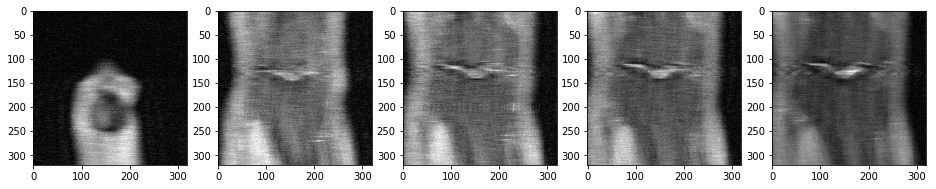

In [27]:
slice_num = [5, 16, 18, 19, 20]
n = 5
show_slices(a, slice_num, cmap='gray')

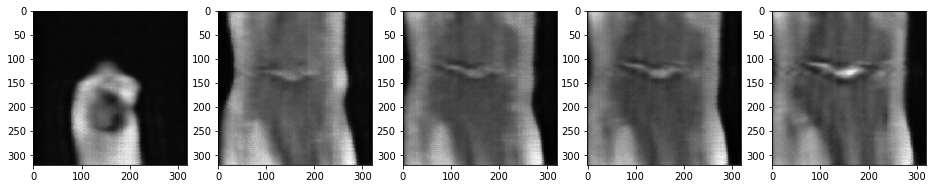

In [30]:
show_slices(out_3d, slice_num, cmap='gray')

In [31]:
fname[-18:-4]+".h5"

'file1000022_v2.h5'

In [32]:
#RESULTS = "results"
#H.create_directory("{}/{}".format(TEST_DATASET_PATH, RESULTS))
#RESULTS_PATH = os.path.join(TEST_DATASET_PATH, RESULTS)
#RESULTS_PATH

In [33]:
res = {}

for path in tqdm(test_images):
    name = path[-18:-4]+".h5"
    
    vol = np.load(path)
    output = predict(vol)
    
    res[name] = output
    
    #np.save("{}/{}".format(RESULTS_PATH, name), output)

100%|██████████| 2/2 [00:14<00:00,  7.00s/it]


In [34]:
print("Done!")

Done!


In [35]:
from fastMRI.common import utils as U
from pathlib import Path

In [36]:
RESULTS_FINAL = "results_final"
H.create_directory("{}/{}".format(TEST_DATASET_PATH, RESULTS_FINAL))
RESULTS_PATH = os.path.join(TEST_DATASET_PATH, RESULTS_FINAL)

In [37]:
RESULTS_PATH

'/home/hasib/MRI-reconstruction/dataset/results_final'

In [38]:
U.save_reconstructions(res, Path(RESULTS_PATH))